Analyses from SWDB are in V1 file


Copied everything over so that I can change function definitions without breaking everything (2017-09-18)

Copied again for (hopefully!) finalized analysis (2017-10-12)

New version with newest ephys data (2017-10-25)

Re-analyze using newest ephys & RNA-seq data downloaded 2018-06-19 (many more cells in RNA-seq set)

Re-do using linear model instead of partial correlations (started 2018-09-25)

In [1]:
# Imports

import sys
import os

import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles
import seaborn as sns
%matplotlib inline


//anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Transform AIBS dataset downloaded from website (ran once & saved)
# Log2(TPM + 1)

# ds = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_exon-matrix.csv', index_col = 0)

# ds_plus_1 = ds.values + 1

# ds_log = np.log2(ds_plus_1)
# ds_log_df = pd.DataFrame(ds_log, index = ds.index, columns = ds.columns)
# ds_log_df.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_exon-matrix_log.csv')


In [3]:
# Returns a dictionary mapping from cell ID to cell type, based on a dataframe containing cell type definitions

def assign_cell_types(raw, mapping, name_to_cre, name_to_class, name_to_layer):

    layer_range_dict = {'L1' : ['L1'],
                        'L1-L2/3' : ['L1', 'L2/3', 'L1-L2/3'],
                        'L1-L4' : ['L1', 'L2/3', 'L4', 'L1-L2/3', 'L2/3-L4', 'L1-L4'],
                        'L1-L6' : ['L2/3', 'L4-L6', 'L1-L2/3', 'L4-L5', 'L6b', 'L2/3-L4', 'L6', 'L5-L6', 'L4', 'L5', 'L1', 'L1-L6', 'L1-L4'],
                        'L2/3' : ['L2/3'],
                        'L2/3-L4' : ['L2/3', 'L4', 'L2/3-L4'],
                        'L4' : ['L4'],
                        'L4-L6' : ['L4', 'L5', 'L6', 'L4-L5', 'L5-L6', 'L4-L6'],
                        'L5' : ['L5'],
                        'L5-L6' : ['L5', 'L6', 'L5-L6'],
                        'L6' : ['L6']}    

    name_to_type = {cell: 'None' for cell in raw.columns}

    for row in mapping.iterrows():
        line, layer, cell_class = row[1][['driver_lines', 'brain_subregion', 'class']]
        defined_type = '__'.join([line, layer, cell_class])
        for cell in raw.columns:
            if name_to_cre[cell] == line:
                if name_to_class[cell] == cell_class:
                    if name_to_layer[cell] in layer_range_dict[layer]:
                        name_to_type[cell] = defined_type

    return name_to_type

In [4]:
# calculates means, SEMs, and counts for each cell type
# If keep_first_only is set to True, returns only the first column of the count dataframe since this is mostly redundant

def collapse(raw, name_to_type, keep_first_only = False):
    
    raw = raw.copy()
    raw.columns = [name_to_type[cell] for cell in raw.columns]
    raw = raw.loc[:, raw.columns != 'None']

    raw = raw.astype(float)
    groups = raw.groupby(raw.columns, axis = 1)
    mean = groups.mean()
    sem = groups.sem()
    count_complete = groups.count()

    threshold = [n >= 6 for n in count_complete.iloc[0].values]
    below_threshold = [n < 6 for n in count_complete.iloc[0].values]
    
    mean = mean.loc[: , threshold]
    sem = sem.loc[: , threshold]
    count = count_complete.loc[: , threshold]
    dropped_types = count_complete.loc[:, below_threshold].iloc[0]
    
    if keep_first_only:
        count = count.iloc[0]
        count_complete = count_complete.iloc[0]

    return mean, sem, count, count_complete, dropped_types


In [5]:
# Merge two dataframes containing cell counts for each type
# If drop is set to True, include only types which are shared across data modalities

def merge_counts(seq_counts, ephys_counts, drop = True):
    counts = pd.concat([seq_counts.T, ephys_counts.T], axis = 1, sort = False)
    if drop:
        counts.dropna(inplace = True)
        counts = counts.astype(int)
    
    return counts

In [6]:
# fit linear models explaining ephys according to gene expression and/or cell class
# returns a summary dataframe containing beta values, class-specific slopes, and p-values

def fit_models(df_seq, df_var2, line_labels, zero_threshold = 2, min_samples = 10):
    
    measures = df_var2.index
    genes = df_seq.index
    
    result_list = []
    
    line_labels = pd.DataFrame(line_labels, index = df_var2.columns, columns = ['cell_class'])
    
    # For each combination of gene and measure, pull out data into x and y variables
    for n, measure in enumerate(measures):
        for m, gene in enumerate(genes):
            if (gene in df_seq.index) & ((df_seq.loc[gene] > 1).sum() >= min_samples):
                x = df_seq.loc[gene, :]
                y = df_var2.loc[measure, :]
                
                # If shapes of x and y make sense, create models
                if x.shape == (df_var2.shape[1],) and y.shape == (df_var2.shape[1],):
                                  
                    # Remove all zero values if there are more than the specified threshold value                
                    not_zero = [val > 0 for val in x]
                    if not_zero.count(False) >= zero_threshold:
                        x = x[not_zero]
                        y = y[not_zero]
                        line_labels_gene = line_labels[not_zero]
                    else:
                        line_labels_gene = line_labels
                    
                    if not_zero.count(True) >= min_samples:

                        # Make a data frame with x and y data plus cell class
                        df_int = pd.concat([x, y, line_labels_gene], axis = 1)
                        gene_idx = 'Gene' + str(gene)
                        df_int.rename(columns = {gene: gene_idx}, inplace = True)

                        # Calculate models
                        mod1 = smf.ols(formula = measure + ' ~ ' + ' +  ' + gene_idx, data = df_int)
                        res1 = mod1.fit()
                        
                        # run class-based models only if both cell types present
                        if set(df_int['cell_class']) == {'exc', 'inh'}:
                            mod2 = smf.ols(formula = measure + ' ~ ' + 'C(cell_class)', data = df_int)
                            mod3 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class)', data = df_int)
                            mod4 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class) + ' + gene_idx + ' * C(cell_class)', data = df_int)
                            res2 = mod2.fit()
                            res3 = mod3.fit()
                            res4 = mod4.fit()

                            a1 = anova_lm(res2, res3)
                            a2 = anova_lm(res3, res4)
                            
                            results = [measure, gene, 
                                       res1.params[gene_idx], res3.params[gene_idx],  
                                       res4.params[gene_idx], res4.params[gene_idx] + res4.params[gene_idx + ':C(cell_class)[T.inh]'], 
                                       res1.pvalues[gene_idx], a1.loc[1, 'Pr(>F)'], a2.loc[1, 'Pr(>F)'], 
                                       res1.aic, res2.aic, res3.aic, res4.aic]
                        else:
                            results = [measure, gene, 
                                       res1.params[gene_idx], np.nan, 
                                       np.nan, np.nan, 
                                       res1.pvalues[gene_idx], np.nan, np.nan, 
                                       res1.aic, np.nan, np.nan, np.nan]
                                                
                        result_list.append(results)
                    
    # Convert to dataframe
    df = pd.DataFrame(result_list, columns = ['ephys_measure', 'gene_entrez_id', 
                                              'beta_gene', 'beta_gene|class', 
                                              'slope_exc', 'slope_inh', 
                                              'pval_gene', 'pval_gene|class_anova', 'pval_int_anova', 
                                              'model1_aic', 'model2_aic', 'model3_aic', 'model4_aic'])
    return df

<h3>Load RNA seq data</h3>

In [7]:
# columns are samples and rows are genes

path_seq = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/mouse_VISp_gene_expression_matrices_2018-06-14/'
filename_seq_log = 'mouse_VISp_2018-06-14_exon-matrix_log.csv'
filename_samples = 'mouse_VISp_2018-06-14_samples-columns.csv'

seq_raw = pd.read_csv(path_seq + filename_seq_log, index_col = 0)
cell_info = pd.read_csv(path_seq + filename_samples, index_col = 0)

cell_info = pd.DataFrame([cell_info['driver_lines'], cell_info['brain_subregion'], 
                          cell_info['class'], cell_info['tdt_cpm'] > 0], 
                         index = ['cre', 'layer_dissection', 'major_class', 'tdTom']).T
seq_name_to_cre = cell_info['cre'].to_dict()
seq_name_to_layer = cell_info['layer_dissection'].to_dict()
cell_info['major_class'] = ['exc' if n == 'Glutamatergic' else 'inh' if n == 'GABAergic' else "Other" for n in cell_info['major_class']]

# Filter out cells that were cre-negative or that did not pass qc, as well as non-neuronal cells
seq_name_to_tdTom = cell_info['tdTom'].to_dict()
seq_name_to_class = cell_info['major_class'].to_dict()
seq_raw = seq_raw.loc[:, [seq_name_to_tdTom[n] for n in seq_raw.columns]]
seq_raw = seq_raw.loc[:, [(seq_name_to_class[n] == 'inh') | (seq_name_to_class[n] == 'exc') for n in seq_raw.columns]]


<h3>Load ephys data</h3>

In [16]:
ephys_features = ['rmp', 'tau', 'apthr', 'apamp', 'ahpamp', 'aphw', 'rheo', 'cap', 'maxfreq', 
                  'adratio', 'ri', 'sag', 'f_i_curve_slope', 'avg_isi', 'latency', 'isi_cv']

path_ephys = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Ephys_Data/'
filename_ephys = 'aibs_aggregated_ephys_v7.csv'
filename_ephys2 = 'cell_types_specimen_details.csv'

ephys_raw = pd.read_csv(path_ephys + filename_ephys, index_col = 0)
extra_ephys_file = pd.read_csv(path_ephys + filename_ephys2, index_col = 0) # tau feature not in main file
ephys_raw.index = ephys_raw.specimen_id
extra_ephys_file.index = extra_ephys_file.specimen__id

# Filter out cre-negative cells
ephys_raw = ephys_raw[ephys_raw.reporter_status == 'positive']
ephys_raw['structure_layer_name'] =['L' + n.replace('a', '').replace('b', '') for n in ephys_raw['structure_layer_name']]
ephys_raw['EI'] = ['exc' if dendrite == 'spiny' else 'inh' if dendrite in ['aspiny', 'sparsely spiny'] else 'Unknown' for dendrite in ephys_raw.dendrite_type]
ephys_name_to_cre = ephys_raw['transgenic_line'].to_dict()
ephys_name_to_layer = ephys_raw['structure_layer_name'].to_dict()
ephys_name_to_class = ephys_raw['EI'].to_dict()

# Rename columns to match NeuroElectro & compute extra measures
ephys_raw['tau'] = [extra_ephys_file.loc[n, 'ef__tau'] if n in extra_ephys_file.index else np.nan for n in ephys_raw.index]
ephys_raw['apamp'] = ephys_raw['peak_v_long_square'] - ephys_raw['threshold_v_long_square']
ephys_raw['ahpamp'] = ephys_raw['threshold_v_long_square'] - ephys_raw['fast_trough_v_long_square']
ephys_raw['aphw'] = ephys_raw['rheo_first_spike_hw'] * 1000
ephys_raw['cap'] = ephys_raw['tau'] / ephys_raw['input_resistance_mohm']

ephys_raw.rename(columns = {'vrest': 'rmp', 'input_resistance_mohm': 'rin', 'threshold_v_long_square': 'apthr',
                           'threshold_i_long_square' : 'rheo', 'max_rate_long_square': 'maxfreq', 
                           'max_rate_first_mean_adratio' : 'adratio', 'hero_isi_cv' : 'isi_cv'}, inplace = True)

# Replace sag values with NaN if resting potential and vm_for_sag are not acceptable values
print('Cells with sag before filtering: ', ephys_raw.sag.count())
if 'sag' in ephys_features:
    ephys_raw['sag'] = ephys_raw['sag'][[(-90 > ephys_raw.loc[cell, 'vm_for_sag'] > -110) & (ephys_raw.loc[cell, 'rmp'] > -80) for cell in ephys_raw.index]]
print('Cells with sag after filtering: ', ephys_raw.sag.count())

ephys_raw = ephys_raw[ephys_features].T


('Cells with sag before filtering: ', 1815)
('Cells with sag after filtering: ', 994)


In [18]:
ephys_raw.shape

(16, 1815)

<h3>Assign cell type labels</h3>

In [9]:
mapping = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/2018_mapping_Sept2018.csv', index_col = 0)
mapping['class'] = ['exc' if n == 'Glutamatergic' else 'inh' if n == 'GABAergic' else n for n in mapping['class']]

In [10]:
seq_name_to_type = assign_cell_types(seq_raw, mapping, seq_name_to_cre, seq_name_to_class, seq_name_to_layer)
ephys_name_to_type = assign_cell_types(ephys_raw, mapping, ephys_name_to_cre, ephys_name_to_class, ephys_name_to_layer)

<h3>Average across cell types, combine RNA-seq + ephys</h3>

In [11]:
seq_mean, seq_sem, seq_count, seq_count_complete, dropped_seq = collapse(seq_raw, seq_name_to_type, keep_first_only = True)
ephys_mean, ephys_sem, ephys_count, ephys_count_complete, dropped_ephys = collapse(ephys_raw, ephys_name_to_type)

dropped = list(dropped_ephys.keys()) + list(dropped_seq.keys())

types_intersect = list(set(seq_mean.columns) & set(ephys_mean.columns))
ephys_only = list(set(ephys_mean.columns).difference(set(seq_mean.columns)))
seq_only = list(set(seq_mean.columns).difference(set(ephys_mean.columns)))
print('Dropped because not present in RNA-seq data:')
print(ephys_only)
print('Dropped because not present in ephys data:')
print(seq_only)
seq_mean = seq_mean.reindex(types_intersect, axis = 1)
ephys_mean = ephys_mean.reindex(types_intersect, axis = 1)

dropped = dropped + ephys_only + seq_only

Dropped because not present in RNA-seq data:
['Nos1-CreERT2|Sst-IRES-FlpO__L1-L4__inh', 'Nos1-CreERT2__L5-L6__exc', 'Scnn1a-Tg3-Cre__L5-L6__exc', 'Chrna2-Cre_OE25__L5__exc']
Dropped because not present in ephys data:
['Slc32a1-T2A-FlpO|Vipr2-IRES2-Cre__L5-L6__inh', 'Gad2-IRES-Cre__L4__inh', 'Oxtr-T2A-Cre__L1-L4__exc', 'Scnn1a-Tg3-Cre__L5-L6__inh', 'Htr3a-Cre_NO152__L1__inh', 'Htr3a-Cre_NO152|Pvalb-T2A-Dre__L1-L4__inh', 'Rbp4-Cre_KL100__L6__exc', 'Gad2-IRES-Cre__L6__inh']


rmp


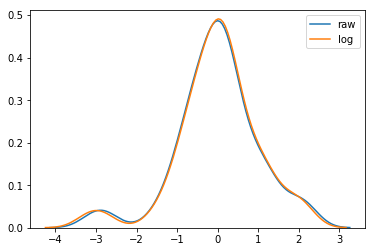

tau


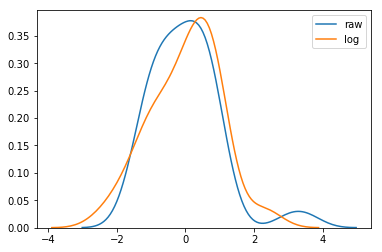

apthr


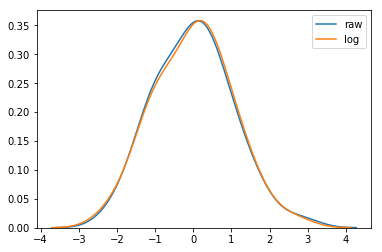

apamp


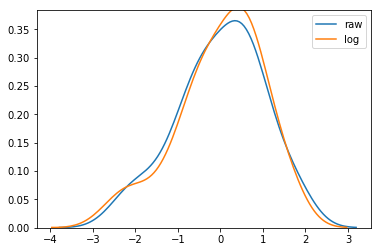

ahpamp


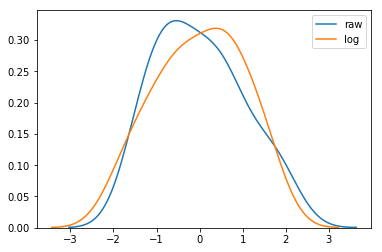

aphw


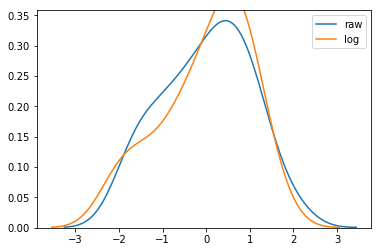

rheo


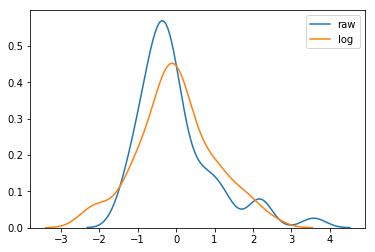

cap


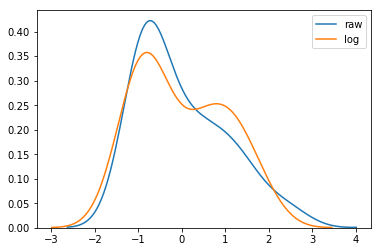

maxfreq


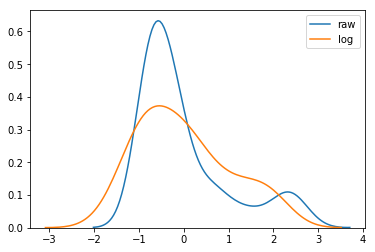

adratio


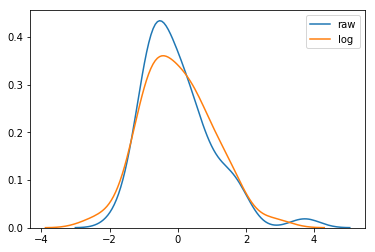

ri


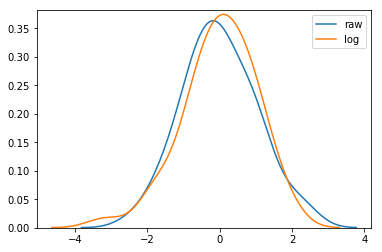

sag


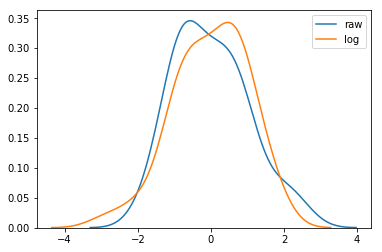

f_i_curve_slope


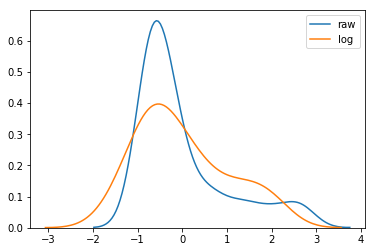

avg_isi


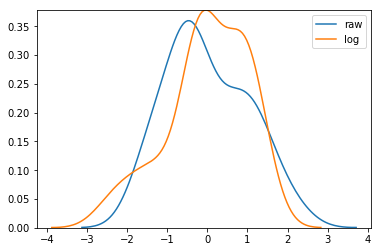

latency


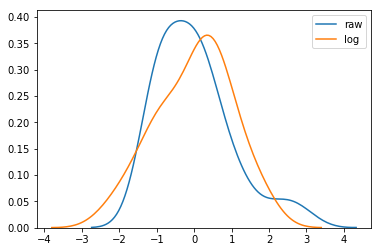

isi_cv


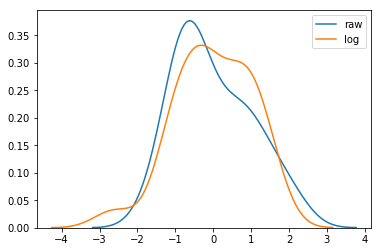

In [12]:
# decide which features to take log of

for measure in ephys_features:
    print(measure)
    sns.kdeplot(stats.zscore(abs(ephys_mean.loc[measure])), label = 'raw')
    sns.kdeplot(stats.zscore(np.log10(abs(ephys_mean.loc[measure]))), label = 'log')
    plt.legend()
    plt.show()

In [13]:
# log transform of measures 
for measure in ['ri', 'tau', 'cap', 'rheo', 'maxfreq', 'ahpamp', 'adratio', 
                'f_i_curve_slope', 'avg_isi', 'latency', 'isi_cv', 'sag']:
    ephys_mean.loc[measure + '_log10'] = np.log10(ephys_mean.loc[measure])
    ephys_features.remove(measure)
    ephys_features.append(measure + '_log10')

<h3>Save metadata</h3>

In [14]:
counts = merge_counts(seq_count, ephys_count, drop = True)
counts_complete = merge_counts(seq_count_complete, ephys_count_complete, drop = False)

counts_complete.rename(columns={counts_complete.columns[0] : "RNA_seq"}, inplace = True)
counts_complete['dropped'] = ['yes' if line in dropped else 'no' for line in counts_complete.index]

counts = counts.iloc[:, [0, 1]]
counts.columns = ['RNA_seq', 'Ephys']

In [15]:
ephys_types = pd.DataFrame.from_dict(ephys_name_to_type, orient = 'index', columns = ['Assigned_Cell_Type'])
seq_types = pd.DataFrame.from_dict(seq_name_to_type, orient = 'index', columns = ['Assigned_Cell_Type'])

ephys_types['Layer'] = [ephys_name_to_layer[n] for n in ephys_types.index]
seq_types['Layer'] = [seq_name_to_layer[n] for n in seq_types.index]
ephys_types['dropped'] = ['yes' if line in dropped else 'no' for line in ephys_types.Assigned_Cell_Type]
seq_types['dropped'] = ['yes' if line in dropped else 'no' for line in seq_types.Assigned_Cell_Type]


In [21]:
output_folder = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-09/'

counts.to_csv(output_folder + 'Counts.csv')
counts_complete.to_csv(output_folder + 'Counts_complete.csv')

seq_types.to_csv(output_folder + 'seq_types.csv')
ephys_types.to_csv(output_folder + 'ephys_types.csv')

seq_mean.to_csv(output_folder + 'seq_mean.csv')
ephys_mean.to_csv(output_folder + 'ephys_mean.csv')

seq_sem.to_csv(output_folder + 'seq_sem.csv')
ephys_sem.to_csv(output_folder + 'ephys_sem.csv')


<h3>OLS regression analysis</h3>

In [18]:
# Remove raw values of features that were log transformed

ephys_mean = ephys_mean.loc[ephys_features]

In [19]:
df_seq = seq_mean
df_ephys = ephys_mean

if not all(df_ephys.columns == df_seq.columns):
    print('Warning: Check inputs!')

line_labels = [line.split('__')[-1] for line in df_ephys.columns]

In [274]:
df = fit_models(df_seq, df_ephys, line_labels)

In [275]:
for ptype in ['pval_gene', 'pval_gene|class_anova', 'pval_int_anova']:
    q_list_all = []
    mask = np.isfinite(df[ptype])
    for measure in ephys_features:
        p_list = np.array(df[mask][df[mask].ephys_measure == measure][ptype])
        _, q_list = fdrcorrection0(p_list, alpha = 0.05)
        q_list_all.append(q_list)
    df[ptype.replace('pval', 'FDR')] = np.nan
    df.loc[mask, ptype.replace('pval', 'FDR')] = np.hstack(q_list_all)

In [276]:
# add gene symbols

filename_genes = 'mouse_VISp_2018-06-14_genes-rows.csv'
gene_info = pd.read_csv(path_seq + filename_genes)
df.insert(2, 'gene_symbol', [gene_info[gene_info.gene_entrez_id == n]['gene_symbol'].values[0] for n in df.gene_entrez_id])


In [277]:
df.to_csv(output_folder + 'results_table.csv')

In [278]:
# percentage of genes with acceptable expression

((float(df.shape[0]) / len(ephys_features)) / float(seq_raw.shape[0])) * 100

26.678028316727843

# Plots

In [285]:
condition_list = ['FDR_gene', 'FDR_gene|class_anova', 'FDR_int_anova']
alpha_list = [0.1, 0.05, 0.01]

sig_dd = {}
counts_dd = {}

for alpha in alpha_list:

    for condition in condition_list:
        sig_d = {}
        counts_d = {}
        for measure in ephys_features:
            qvals = df[df.ephys_measure == measure]
            genes_sig = qvals[qvals[condition] < alpha]['gene_entrez_id'].values
            sig_d[measure] = genes_sig
            counts_d[measure] = len(genes_sig)
        sig_dd[(condition, alpha)] = sig_d
        counts_dd[(condition, alpha)] = counts_d

In [286]:
# E~G versus E~G|C

conditions = ['FDR_gene', 'FDR_gene|class_anova', 'FDR_int_anova']

for alpha in alpha_list:
    fig, ax = plt.subplots(4, 5, figsize = (12, 10))
    v = []
    for i, measure in enumerate(ephys_features):
        set1 = set(sig_dd[(conditions[0], alpha)][measure])
        set2 = set(sig_dd[(conditions[1], alpha)][measure])
        set3 = set(sig_dd[(conditions[2], alpha)][measure])

        venn = venn3([set1, set2, set3], set_labels = None, set_colors = ('g', 'b', 'r'), ax = ax.flatten()[i])
        v.append(venn)
        ax.flatten()[i].set_title(measure[:16] + '\n' + measure[16:], loc = 'center')

    green_patch = v[3].get_patch_by_id('100')
    blue_patch = v[3].get_patch_by_id('010')
    red_patch = v[3].get_patch_by_id('001')
    
    fig.delaxes(ax.flatten()[len(ax.flatten()) - 1])
    plt.legend(handles=[green_patch, blue_patch, red_patch], labels = ['ephys~gene', 'ephys~gene|class', 'interaction'], 
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    fig.suptitle('Number of genes detected (FDR < ' + str(alpha) + ')', fontsize = 18)
    plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-09/venn' + str(alpha) + '.png', bbox_inches='tight')
    plt.close('all')
#     plt.show()

In [25]:
# re-run model #2 (E~C) for each ephys/morphology feature

df_var2 = df_ephys
    
measures = df_var2.index

result_list = []

line_labels = pd.DataFrame(line_labels, index = df_var2.columns, columns = ['cell_class'])

# For each measure, pull out data into and y variable
for n, measure in enumerate(measures):
    y = df_var2.loc[measure, :]

    # If shape of y makes sense, create models
    if y.shape == (df_var2.shape[1],):

        # Make a data frame with y data plus cell class
        df_int = pd.concat([y, line_labels], axis = 1)

        # run class-based model only if both cell types present
        if set(df_int['cell_class']) == {'exc', 'inh'}:
            mod2 = smf.ols(formula = measure + ' ~ ' + 'C(cell_class)', data = df_int)
            res2 = mod2.fit()
            results = [measure, res2.params['C(cell_class)[T.inh]'], res2.pvalues['C(cell_class)[T.inh]']]
        else:
            results = [measure, np.nan, np.nan]

        result_list.append(results)

# Convert to dataframe
df_class = pd.DataFrame(result_list, columns = ['ephys_measure', 'beta_class', 'pval_class'])


In [30]:
ptype = 'pval_class'
mask = np.isfinite(df_class[ptype])
p_list = np.array(df_class[mask][ptype])
_, q_list = fdrcorrection0(p_list, alpha = 0.05)
df_class[ptype.replace('pval', 'FDR')] = np.nan
df_class.loc[mask, ptype.replace('pval', 'FDR')] = np.hstack(q_list)

In [34]:
output_folder = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-09/'

df_class.to_csv(output_folder + 'results_table_class.csv')